In [1]:
import pandas as pd
from orbit.models import ETS
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester
from orbit.models import KTR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from concurrent.futures import ThreadPoolExecutor
import concurrent
import json
from typing import Any, Callable, Dict, Tuple
import itertools
from metrics import print_evaluation_metrics

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path)
df = df[[date_column, target_column, "New_cases"]]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
df[date_column] = pd.to_datetime(df.pop(date_column), format="%Y-%m-%d")
# df.set_index(date_time, inplace=True, drop=False)

train = df.iloc[:-30]
valid = df.iloc[-30:]

In [3]:
def evaluate_grid(
    model_function: Callable[[Dict[str, Any], str, str], Any],
    grid: Dict[str, Any],
    train: pd.DataFrame,
    date_column: str,
    target_column: str,
) -> Tuple[Dict[str, Any], float]:
    """
    Evaluate a forecasting model on a given parameter grid.

    This function uses a model creation function to initialize a model with the provided
    grid of parameters, performs backtesting using the provided training data, and computes
    the root mean squared error (RMSE) of the predictions.

    Parameters:
    - model_function (Callable[[Dict[str, Any], str, str], Any]): A function that creates
      a model instance. It should accept a parameter grid, a date column name, and a target
      column name.
    - grid (Dict[str, Any]): A dictionary containing the parameters for the model.
    - train (pd.DataFrame): The training dataset as a Pandas DataFrame.
    - date_column (str): The name of the column in 'train' that contains the date information.
    - target_column (str): The name of the target column in 'train'.

    Returns:
    - Tuple[Dict[str, Any], float]: A tuple containing the grid of parameters and the
      corresponding RMSE score.
    """
    model = model_function(grid, date_column, target_column)

    bt = BackTester(
        df=train, model=model, forecast_len=90, n_splits=5, window_type="rolling"
    )

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    score = sqrt(mean_squared_error(predicted_df["actual"], predicted_df["prediction"]))
    return grid, score

In [4]:
param_grid = {
    "seasonality": [None, 90, 180, 360],
    "level_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
    "seasonality_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [5]:
ets_scores = dict()


def ets_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an ETS model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the ETS model configured with the given parameters.
    """
    return ETS(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        seed=1,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, ets_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        ets_scores[json.dumps(option)] = score

2023-12-10 11:25:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:25:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:25:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:25:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































chain 1 |██▌       | 00:00 Status

















































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
































































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




















































































































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     





























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


2023-12-10 11:25:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:25:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















2023-12-10 11:25:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:25:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status













































































































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)











































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     













chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-12-10 11:25:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-10 11:25:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:25:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2023-12-10 11:25:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



















chain 1 |          






























































chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)





















































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     








chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


2023-12-10 11:25:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
2023-12-10 11:25:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















2023-12-10 11:25:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:25:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |          | 00:01 Iteration: 2
















chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




































































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     




















2023-12-10 11:25:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















chain 1 |          | 00:00 Status






































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2023-12-10 11:25:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status




2023-12-10 11:25:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:25:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






















































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






















































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)





















2023-12-10 11:25:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































chain 1 |██████████| 00:01 Sampling completed        





























































































chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




























































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     









chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2023-12-10 11:25:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:25:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















2023-12-10 11:25:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:25:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 3 |          | 00:00 Status




































chain 1 |██▌       | 00:00 Status

























































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     









2023-12-10 11:25:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     











































chain 4 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-10 11:25:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status






chain 1 |██▌       | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)A
2023-12-10 11:25:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     














2023-12-10 11:25:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status








2023-12-10 11:25:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






2023-12-10 11:25:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                  




chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
































































































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)






























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     













chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

2023-12-10 11:25:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |          | 00:00 Statusion: 100 / 250 [ 40%]  (Warmup)






























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 4 |          | 00:00 Status

chain 1 |██▌       | 00:00 Status












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   





chain 4 |██▌       | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:25:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

2023-12-10 11:25:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





2023-12-10 11:25:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status









































































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






























2023-12-10 11:25:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:00 Sampling completed                     

















chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:25:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-10 11:25:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |██▌       | 00:00 Status













chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





2023-12-10 11:25:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:25:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     











chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     




















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-10 11:25:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



2023-12-10 11:25:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

2023-12-10 11:25:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































2023-12-10 11:25:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 










































































































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2023-12-10 11:25:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















chain 1 |          | 00:00 Status











































chain 1 |██████████| 00:00 Sampling completed                   












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed

2023-12-10 11:25:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
2023-12-10 11:25:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:25:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

























































chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:25:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































chain





































































































chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



























































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     
























chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     

















chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                   












chain 2 |██████████| 00:00 Sampling completed


chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:26:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:26:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

2023-12-10 11:26:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sa







































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     






















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

2023-12-10 11:26:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
2023-12-10 11:26:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















2023-12-10 11:26:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
















2023-12-10 11:26:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


























































































2023-12-10 11:26:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status
















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




























































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     




chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     



chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |          | 00:00 Status



















chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






2023-12-10 11:26:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |          | 00:00 Status










































chain 1 |██▌       | 00:00 Status















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



2023-12-10 11:26:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     





















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     












2023-12-10 11:26:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Sampling completed                     




chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
2023-12-10 11:26:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















2023-12-10 11:26:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   








chain 4 |██████████| 00:00 Sampling completed                     


chain 3 |          | 00:00 Status






















chain 3 |██▌       | 00:00 Status







chain 4 |██▌       | 00:00 Status



















chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
















2023-12-10 11:26:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:00 Sampling completed                     







chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   
































chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

2023-12-10 11:26:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     
























chain 1 |██████████| 00:00 Sampling completed                     






chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     






chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     2023-12-10 11:26:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
2023-12-10 11:26:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










2023-12-10 11:26:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   








chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status




















chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:26:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

































































chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)










































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     2023-12-10 11:26:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 4 |██████████| 00:00 Sampling completed  

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:00 Status






























chain 1 |██▌       | 00:00 Status
















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     





chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   


chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     2023-12-10 11:26:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status


chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)



















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)































2023-12-10 11:26:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |          | 00:00 Statusion: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██▌       | 00:00 Status































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   


2023-12-10 11:26:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status2023-12-10 11:26:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |██▌       | 00:00 Status






















2023-12-10 11:26:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





























































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)






























































2023-12-10 11:26:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































chain 1 |██████████| 00:01 Sampling completed               




















































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   









chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   

2023-12-10 11:26:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-10 11:26:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:26:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2023-12-10 11:26:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
























































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     











chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


2023-12-10 11:26:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2023-12-10 11:26:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |██▌       | 00:00 Status















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



2023-12-10 11:26:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:26:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     














chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   










chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:26:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

2023-12-10 11:26:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2023-12-10 11:26:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)













































































































































chain 1 |          | 00:00 Iteration: 226 /



















































chain 1 |██████████| 00:00 Sampling completed                   


chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     








chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     
















chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

2023-12-10 11:26:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:26:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:26:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









2023-12-10 11:26:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |██▌       | 00:00 Status





























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

































































































































chain 1 |██






































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     
























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-12-10 11:26:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-10 11:26:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























2023-12-10 11:26:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2023-12-10 11:26:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































































chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)



























chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     






















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

2023-12-10 11:26:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:26:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2023-12-10 11:26:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)









































































































chain 3 |██▌       | 00:00 Status

chain 3 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



















2023-12-10 11:26:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

chain 4 |          | 00:00 Status

chain 1 |██▌       | 00:00 Status















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

2023-12-10 11:26:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)



























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     












2023-12-10 11:26:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:26:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status















































chain 1 |██▌       | 00:00 Status








chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     









chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     










chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)














































chain 1 |██████████| 00:00 Sampling completed                   g)


chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     



2023-12-10 11:26:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   









2023-12-10 11:26:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















2023-12-10 11:26:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
2023-12-10 11:26:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2023-12-10 11:26:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status

2023-12-10 11:26:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



















2023-12-10 11:26:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |          | 00:00 Status











2023-12-10 11:26:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 2 |██▌       | 00:00 Status







chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 1 |██████████| 00:00 Sampling completed                     





chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     






chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



























2023-12-10 11:26:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)






















2023-12-10 11:26:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     



chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:00 Status



















2023-12-10 11:26:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:00 Sampling completed                     



chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 2 |          | 00:00 Status















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


































2023-12-10 11:26:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Sampling completed                     










chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status


















chain 1 |██▌       | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                     

chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)A







































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:26:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 3 |          | 00:00 Status



2023-12-10 11:26:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |██▌       | 00:00 Status























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
















2023-12-10 11:26:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     










chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status



chain 1 |██████████| 00:00 Sampling completed                     




chain 2 |██████████| 00:00 Sampling completed





chain 3 |██████████| 00:00 Sampling completed






chain 2 |██▌       | 00:00 Status






chain 4 |██████████| 00:00 Sampling completed




chain 4 |██▌       | 00:00 Status

2023-12-10 11:26:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     






chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |██████████| 00:00 Sampling completed                   


chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:26:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-10 11:26:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status





chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)



















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     




















2023-12-10 11:26:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 1 |          | 00:00 Status





chain 4 |██████████| 00:00 Sampling completed




chain 1 |██▌       | 00:00 Status


2023-12-10 11:26:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

2023-12-10 11:26:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






























































































































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     2023-12-10 11:26:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 3 |██████████| 00:00 Sampling completed                   
ch

chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |          | 00:00 Status










chain 1 |██▌       | 00:00 Status
















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     





chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                   


chain 2 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:26:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:26:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










2023-12-10 11:26:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed  






































2023-12-10 11:26:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |          | 00:00 Status































chain 1 |██▌       | 00:00 Status

















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     









chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     





chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)A
2023-12-10 11:26:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     













chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   






chain 4 |██████████| 00:00 Sampling completed


2023-12-10 11:26:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     









chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:26:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status





2023-12-10 11:26:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |██▌       | 00:00 Status




















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)















































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     





chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)














































2023-12-10 11:26:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   






















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   







chain 4 |██████████| 00:00 Sampling completed                   









chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2023-12-10 11:26:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


2023-12-10 11:26:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:26:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

























































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)










































































2023-12-10 11:26:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |████████






































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     












chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     




























chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:26:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:26:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
chain 2 |          | 00:00 Status2023-12-10 11:26:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |██▌       | 00:00 Status


















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














2023-12-10 11:26:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

































































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     










chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:26:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:26:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:26:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |██████████| 00:00 Sampling completed             



























































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     
































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:26:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

chain 2 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

2023-12-10 11:26:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)










2023-12-10 11:26:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status
























chain 1 |██▌       | 00:00 Status

















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   



chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:26:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   






chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   


chain 2 |██▌       | 00:00 Status








2023-12-10 11:26:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |          | 00:00 Statusion: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:26:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





















































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)









































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:26:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status





chain 1 |██████████| 00:01 Sampling completed                     




chain 2 |██████████| 00:01 Sampling completed
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |          | 00:00 Status














chain 1 |██████████| 00:00 Sampling completed                     


chain 2 |██████████| 00:00 Sampling completed                     











chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                   


chain 1 |██▌       | 00:00 Status


chain 2 |██▌       | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
2023-12-10 11:26:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-10 11:26:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status































2023-12-10 11:26:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





























chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

























2023-12-10 11:26:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   




chain 3 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
2023-12-10 11:26:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 2 |          | 00:00 Status




2023-12-10 11:26:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status




















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)23-12-10 11:26:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |██████████| 00:00 Sampling completed                   










chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |█████████


chain 4 |██████████| 00:00 Sampling completed                   












chain 1 |██████████| 00:00 Sampling completed                     s: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 2 |██████████| 00:00 Sampling completed                   









chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status



chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:26:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:26:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:26:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




































































2023-12-10 11:26:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






























































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 1 |██████████| 00:00 Sampling completed                   

chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   






chain 1 |██████████| 00:00 Sampling completed                     













chain 2 |██████████| 00:00 Sampling completed                     












chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   














chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:27:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
2023-12-10 11:27:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:27:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2023-12-10 11:27:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





















































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     














chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:27:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:27:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:27:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

































































































































































chain 1 |██████████| 00:00 Sampling completed                   









chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     



chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-10 11:27:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:27:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







































































































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     












chain 2 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

2023-12-10 11:27:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)








































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     







chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-10 11:27:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-10 11:27:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-10 11:27:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)













































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)








































































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)










2023-12-10 11:27:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     













chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


2023-12-10 11:27:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


2023-12-10 11:27:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2023-12-10 11:27:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)











































































chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)































chain 1 |██████████| 00:11 Sampling compl



















2023-12-10 11:27:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


























2023-12-10 11:27:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status









































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-10 11:27:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-10 11:27:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




























2023-12-10 11:27:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

























2023-12-10 11:27:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-10 11:27:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     




2023-12-10 11:27:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)
































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     














2023-12-10 11:27:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status


























































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     







































2023-12-10 11:27:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     



chain 2 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)

2023-12-10 11:27:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



















2023-12-10 11:28:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 1 |          | 00:00 Status














































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     
















chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

















2023-12-10 11:28:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:28:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     












































































2023-12-10 11:28:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


















































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




























chain 4 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

















2023-12-10 11:28:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















2023-12-10 11:28:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     








chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)






















2023-12-10 11:28:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2023-12-10 11:28:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-10 11:28:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)
































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00




























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




















chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     




chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

2023-12-10 11:28:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:28:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































2023-12-10 11:28:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     




















2023-12-10 11:28:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     
























2023-12-10 11:28:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)














































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     







chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     
















chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-12-10 11:28:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
2023-12-10 11:28:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























2023-12-10 11:28:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:28:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


















































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:02 

2023-12-10 11:28:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)




































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)




















































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     














2023-12-10 11:28:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)















2023-12-10 11:28:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




chain 4 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:28:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     



chain 4 |██████████| 00:02 Sampling completed                     

chain 2 |          | 00:00 Status





chain 2 |██▌       | 00:00 Status
























2023-12-10 11:28:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































2023-12-10 11:28:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 2 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)














































































chain 2 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 2 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed          






chain 2 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)






























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     























2023-12-10 11:28:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 3 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |          | 00:00 Status

























































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     























2023-12-10 11:28:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     



2023-12-10 11:28:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2023-12-10 11:28:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)










































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     



















































































2023-12-10 11:28:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 4 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


























2023-12-10 11:28:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
















































2023-12-10 11:28:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)








































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)


























































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)










































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                   


















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 2 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)













































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     


chain 3 |██████████| 00:03 Sampling completed                     


chain 4 |██████████| 00:03 Sampling completed                     

2023-12-10 11:28:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
2023-12-10 11:28:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















2023-12-10 11:28:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:28:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     






chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2023-12-10 11:28:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-10 11:28:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2023-12-10 11:28:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)









































chain 1 |██████████| 00:08 Sampling completed                     
chain 










































































2023-12-10 11:28:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























































































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     
















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-10 11:28:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-10 11:28:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-10 11:28:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                






































































2023-12-10 11:29:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























































































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 2 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


2023-12-10 11:29:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































2023-12-10 11:29:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-10 11:29:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



















2023-12-10 11:29:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-12-10 11:29:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































2023-12-10 11:29:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-10 11:29:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)




























































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)

































chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     































2023-12-10 11:29:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     











chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-10 11:29:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































2023-12-10 11:29:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-10 11:29:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)
























































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)






















































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     




chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     



2023-12-10 11:29:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:29:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-10 11:29:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     




































2023-12-10 11:29:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)






















































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)












2023-12-10 11:29:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-10 11:29:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)










2023-12-10 11:29:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)





































































chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)






























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     















2023-12-10 11:29:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     














2023-12-10 11:29:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status





































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)

































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     







chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 2 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:29:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     










































2023-12-10 11:29:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


















2023-12-10 11:29:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:30:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     












2023-12-10 11:30:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
















































































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     














2023-12-10 11:30:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-10 11:30:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:30:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-10 11:30:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























































































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     










2023-12-10 11:30:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)

2023-12-10 11:30:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


2023-12-10 11:30:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status





2023-12-10 11:30:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



























2023-12-10 11:30:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)

















































chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     










chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     









chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-10 11:30:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-10 11:30:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-10 11:30:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

















































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |






chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:30:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-12-10 11:30:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     









2023-12-10 11:30:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)






































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     





2023-12-10 11:30:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     








2023-12-10 11:30:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |          | 00:00 Status












































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     



























2023-12-10 11:30:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     















chain 2 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:30:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:30:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)





































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed        




































2023-12-10 11:30:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |          | 00:00 Status






































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

































2023-12-10 11:30:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


























2023-12-10 11:30:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     















2023-12-10 11:30:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




































































2023-12-10 11:30:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





































2023-12-10 11:31:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)











































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)





































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     









chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-10 11:31:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




































2023-12-10 11:31:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     








chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-10 11:31:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     











2023-12-10 11:31:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


chain 1 |██▌       | 00:00 Status














2023-12-10 11:31:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     






















2023-12-10 11:31:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)






















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     
























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 4 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)




























































2023-12-10 11:31:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:31:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-10 11:31:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |██▌       | 00:00 Status

















































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |

2023-12-10 11:31:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     










2023-12-10 11:31:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)



































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




























































2023-12-10 11:31:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:31:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     








2023-12-10 11:31:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2023-12-10 11:31:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




chain 3 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)






















2023-12-10 11:31:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)

















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     







2023-12-10 11:31:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




2023-12-10 11:31:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     









2023-12-10 11:31:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)























chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



chain 2 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                     2023-12-10 11:31:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |          | 00:00 Status





2023-12-10 11:31:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






























2023-12-10 11:31:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     



chain 2 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

2023-12-10 11:31:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-10 11:31:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status


































































































































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     











chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     






chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)



















2023-12-10 11:32:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































2023-12-10 11:32:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:32:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)






















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

























2023-12-10 11:32:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     














2023-12-10 11:32:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-10 11:32:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)









































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)






























chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)














































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     



























































2023-12-10 11:32:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 4 |          | 00:00 Status










chain 4 |██▌       | 00:00 Status















chain 3 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)


































































2023-12-10 11:32:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     



















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


2023-12-10 11:32:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































2023-12-10 11:32:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































chain 4 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


















































chain 4 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)





















chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     











chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     













































































2023-12-10 11:32:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     






chain 2 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)


2023-12-10 11:32:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






2023-12-10 11:32:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


2023-12-10 11:32:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status









































2023-12-10 11:32:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-10 11:32:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     












chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)






























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


2023-12-10 11:32:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2023-12-10 11:32:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)



































chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     










2023-12-10 11:32:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     









2023-12-10 11:32:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


































2023-12-10 11:32:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     











chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)



































2023-12-10 11:32:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)












































chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-10 11:32:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     















chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     


2023-12-10 11:32:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status




















2023-12-10 11:32:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     
















chain 3 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)










2023-12-10 11:33:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)








































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)









2023-12-10 11:33:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)














































































chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)















































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     







chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-10 11:33:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status



















2023-12-10 11:33:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     








































2023-12-10 11:33:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)




























































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)

















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     












chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-10 11:33:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2023-12-10 11:33:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     













2023-12-10 11:33:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     







2023-12-10 11:33:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     












chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     














chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-10 11:33:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)
























































2023-12-10 11:33:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     












chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-10 11:33:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:33:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     















2023-12-10 11:33:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)




















































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)










2023-12-10 11:33:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)





























































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

















2023-12-10 11:33:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     












2023-12-10 11:33:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     












2023-12-10 11:33:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     











2023-12-10 11:33:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)































































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)



























































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     














chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     



























2023-12-10 11:33:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-10 11:33:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































































































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)










chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-10 11:34:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)






































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     






2023-12-10 11:34:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status


























































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-10 11:34:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     
















































2023-12-10 11:34:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:34:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)





































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     








2023-12-10 11:34:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-12-10 11:34:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:34:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     









2023-12-10 11:34:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-10 11:34:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)
















chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)














































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     



2023-12-10 11:34:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     






2023-12-10 11:34:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2023-12-10 11:34:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)


















chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)






























































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     



2023-12-10 11:34:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     










2023-12-10 11:34:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     


























2023-12-10 11:34:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     











2023-12-10 11:34:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:34:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)



























chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     






































































2023-12-10 11:35:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















































































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)









































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)





























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████


chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     




chain 2 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)


























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     



chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     


chain 4 |██████████| 00:02 Sampling completed                     

2023-12-10 11:35:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:35:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






















2023-12-10 11:35:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |██▌       | 00:00 Status













































2023-12-10 11:35:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 2 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)










2023-12-10 11:35:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 3 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:35:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)







































































































chain 1 |██████████| 00:06 Sampling completed                     







chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |████████

chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)





























2023-12-10 11:35:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)







































































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)



























































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     










chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     











chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2023-12-10 11:35:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











2023-12-10 11:35:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































2023-12-10 11:35:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































































































































































































































































chain 1 |██████████| 00:04 Sampling co
































2023-12-10 11:35:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     







2023-12-10 11:35:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































2023-12-10 11:35:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)


















































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)



































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |█████
















chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-10 11:35:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


2023-12-10 11:35:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































2023-12-10 11:35:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)


















































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)






















































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 3 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 3 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)




































2023-12-10 11:35:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     
















































2023-12-10 11:35:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)






























chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)





































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     







chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     


2023-12-10 11:35:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status











chain 1 |██▌       | 00:00 Status











2023-12-10 11:35:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2023-12-10 11:35:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)





















chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)


















chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)


















































































































































































































chain 1 |██████████| 00:0




















































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


























2023-12-10 11:35:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


2023-12-10 11:35:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     












chain 3 |██▌       | 00:00 Status



































2023-12-10 11:35:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









2023-12-10 11:35:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)



































































































































































































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)














































chain 1 |██████████| 00:05 Sampling completed                 













































2023-12-10 11:35:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     













chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     










chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-10 11:35:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:35:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































2023-12-10 11:35:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling c

chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)






2023-12-10 11:35:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     













2023-12-10 11:36:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)



























































chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     






























































chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:36:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     





















































2023-12-10 11:36:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     







































2023-12-10 11:36:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     














































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


2023-12-10 11:36:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2023-12-10 11:36:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













2023-12-10 11:36:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2023-12-10 11:36:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)

















































































































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)

































chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)














































































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed       


chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     



2023-12-10 11:36:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:36:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






















































































2023-12-10 11:36:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:36:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)



















































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)



























2023-12-10 11:36:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)


















chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-12-10 11:36:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2023-12-10 11:36:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:36:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)












































































chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)








































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     


































2023-12-10 11:36:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:00 Status



















chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     



























































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-10 11:37:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











2023-12-10 11:37:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2023-12-10 11:37:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)

































































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 3 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     




2023-12-10 11:37:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























2023-12-10 11:37:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     













2023-12-10 11:37:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

2023-12-10 11:37:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































































































































































































































































chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)












































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     
























chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


chain 1 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:17 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     







chain 1 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)






2023-12-10 11:37:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2023-12-10 11:37:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























2023-12-10 11:37:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































2023-12-10 11:37:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)










































chain 1 |██████████| 00:08 Sampling complet













2023-12-10 11:37:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-10 11:37:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















































































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)









































































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)







































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     




chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)




2023-12-10 11:37:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-10 11:37:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-10 11:37:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-10 11:37:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















































































































































































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)

























































































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)

































chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed 

















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     














2023-12-10 11:38:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

chain 1 |          | 00:00 Status








chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     


chain 4 |██████████| 00:14 Sampling completed                     


chain 1 |██▌       | 00:00 Status




2023-12-10 11:38:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























2023-12-10 11:38:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2023-12-10 11:38:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)





























































chain 1 |███





































chain 1 |          | 00:00 Statusion:   1 / 250 [  0%]  (Warmup)2023-12-10 11:38:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     



























chain 4 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)



















chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     









2023-12-10 11:38:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-12-10 11:38:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































2023-12-10 11:38:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)















chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)



































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed      















chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     





















































chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2023-12-10 11:38:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-10 11:38:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     















2023-12-10 11:38:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)







































































chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)














































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-10 11:38:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




2023-12-10 11:38:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

2023-12-10 11:39:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)



















































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     





2023-12-10 11:39:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     



chain 2 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     






































2023-12-10 11:39:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:39:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-10 11:39:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-10 11:39:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)







































































chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)



























































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     





















chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     








chain 3 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:11 Sampling completed                     


chain 2 |██████████| 00:11 Sampling completed                     2023-12-10 11:39:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

























2023-12-10 11:39:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:39:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-12-10 11:39:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██▌       | 00:00 Status














































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-10 11:39:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-10 11:39:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)












































chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)




















chain 1 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)











































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     





2023-12-10 11:39:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     































2023-12-10 11:39:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     































2023-12-10 11:39:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-12-10 11:39:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)











































chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)


































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     




chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:40:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









chain 1 |██▌       | 00:00 Status


2023-12-10 11:40:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-10 11:40:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)
















































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:40:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


2023-12-10 11:40:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     




2023-12-10 11:40:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     













2023-12-10 11:40:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

























2023-12-10 11:40:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     









2023-12-10 11:40:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     






chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     



















2023-12-10 11:40:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:40:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














chain 1 |██▌       | 00:00 Status



















































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






















2023-12-10 11:40:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     














2023-12-10 11:40:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)




















































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     















chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-10 11:40:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-10 11:40:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:40:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)










































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)











2023-12-10 11:41:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)



























chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     
















chain 1 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)




























2023-12-10 11:41:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 1 |          | 00:00 Status


































2023-12-10 11:41:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     


































2023-12-10 11:41:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)



2023-12-10 11:41:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)





















chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)























chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     



















chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


2023-12-10 11:41:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status





2023-12-10 11:41:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)


















chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)





























































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     






























2023-12-10 11:41:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     











2023-12-10 11:41:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



2023-12-10 11:41:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-10 11:41:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























































































































































































































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)





























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     





chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     












chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)







2023-12-10 11:41:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     







2023-12-10 11:41:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































2023-12-10 11:41:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-10 11:41:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
































































































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-10 11:41:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


2023-12-10 11:41:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)





















































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)
















2023-12-10 11:41:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     





































































2023-12-10 11:41:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-10 11:41:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-10 11:42:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)
























































































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling c












chain 3 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     





























2023-12-10 11:42:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-10 11:42:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     










chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)








2023-12-10 11:42:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:42:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)











































































































































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████|







chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


2023-12-10 11:42:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |          | 00:00 Status

























2023-12-10 11:42:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

chain 2 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)





2023-12-10 11:42:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     









2023-12-10 11:42:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)


























































































































































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)















































chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)




















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     














chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     







2023-12-10 11:42:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status






2023-12-10 11:42:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








2023-12-10 11:42:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                   

2023-12-10 11:42:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)



























































chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)


















































































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)






























































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


































2023-12-10 11:42:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     
























chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


2023-12-10 11:42:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































2023-12-10 11:42:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-10 11:42:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)









































































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)





























chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)










































chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)






























































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed       










































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     


chain 3 |██████████| 00:10 Sampling completed                     


chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


2023-12-10 11:43:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:43:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










2023-12-10 11:43:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































2023-12-10 11:43:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)






























2023-12-10 11:43:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















2023-12-10 11:43:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-10 11:43:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-10 11:43:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     




2023-12-10 11:43:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     
















chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     



chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-10 11:43:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










2023-12-10 11:43:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-10 11:43:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed       


chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)






2023-12-10 11:43:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     














chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     












chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-10 11:43:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status





2023-12-10 11:43:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-10 11:43:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     



2023-12-10 11:43:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)





















































































































































































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)




















































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     










2023-12-10 11:44:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     







chain 2 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 4 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     












2023-12-10 11:44:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     



chain 2 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status


2023-12-10 11:44:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































2023-12-10 11:44:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































































































































chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)














































































chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)















































chain 1 |█████████


chain 1 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)

































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     




2023-12-10 11:44:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-10 11:44:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     






2023-12-10 11:44:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2023-12-10 11:44:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














































































































































































































































chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)




































































































chain 1 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

chain 1 |██████████| 00:17 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

chain 1 |          | 00:18 Iteration: 226 / 250 [ 90%]  (Sampling)




2023-12-10 11:44:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































2023-12-10 11:44:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     





2023-12-10 11:44:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     

2023-12-10 11:44:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)






















































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)





























































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)


















chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)








































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed       




chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     









































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:45:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:45:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












chain 1 |██▌       | 00:00 Status































































2023-12-10 11:45:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     













































2023-12-10 11:45:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     



































2023-12-10 11:45:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)




















































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)










































2023-12-10 11:45:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     









2023-12-10 11:45:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































2023-12-10 11:45:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 3 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)







2023-12-10 11:45:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:00 Status




















































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

















2023-12-10 11:45:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     









chain 4 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 2 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)













2023-12-10 11:45:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


































2023-12-10 11:45:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)



























































































































































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)




















































chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     









chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     











chain 4 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)





























2023-12-10 11:45:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 2 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:45:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 2 |          | 00:00 Status















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2023-12-10 11:45:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























2023-12-10 11:45:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 2 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)












chain 2 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)






























































chain 2 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)


































chain 2 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)



































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                













2023-12-10 11:45:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |          | 00:00 Status




















2023-12-10 11:45:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)

























































































































































































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)






































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed              


chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


2023-12-10 11:45:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 3 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status


2023-12-10 11:45:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































2023-12-10 11:45:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































2023-12-10 11:45:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
c





chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-10 11:45:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























2023-12-10 11:45:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)




















































































































chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)

































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sam















2023-12-10 11:46:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

























chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     












2023-12-10 11:46:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

















































































2023-12-10 11:46:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)

















































































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     























2023-12-10 11:46:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     






















2023-12-10 11:46:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


























2023-12-10 11:46:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status








































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     











2023-12-10 11:46:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-10 11:46:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































































































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




chain 3 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)

2023-12-10 11:46:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































2023-12-10 11:46:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)


































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     










































2023-12-10 11:46:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





















2023-12-10 11:46:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     








2023-12-10 11:46:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     











































2023-12-10 11:46:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     




















2023-12-10 11:46:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






















2023-12-10 11:46:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





























chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:46:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)



















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-12-10 11:46:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































2023-12-10 11:46:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-10 11:46:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








































































































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     


























































2023-12-10 11:46:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)

















































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-10 11:47:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)


































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     





2023-12-10 11:47:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 2 |██▌       | 00:00 Status2023-12-10 11:47:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     









chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-10 11:47:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-10 11:47:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)






















chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)











































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                   















































2023-12-10 11:47:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




























































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     




























































2023-12-10 11:47:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

















2023-12-10 11:47:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-10 11:47:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)
































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)



















































































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Samp

chain 4 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)
























2023-12-10 11:47:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     


















chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     







chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:47:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-10 11:47:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-10 11:47:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)























































































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)

























































chain 1 |          | 0





2023-12-10 11:47:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

chain 2 |          | 00:00 Status






















chain 1 |██▌       | 00:00 Status




































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     













2023-12-10 11:47:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-10 11:47:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

2023-12-10 11:48:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)















































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:11 Sampling completed                     





chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     










2023-12-10 11:48:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     









chain 4 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     














2023-12-10 11:48:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-10 11:48:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     





































2023-12-10 11:48:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)




2023-12-10 11:48:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-10 11:48:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     



























2023-12-10 11:48:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     












chain 3 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:48:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-10 11:48:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-10 11:48:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






chain 1 |██▌       | 00:00 Status

















































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:48:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)












































































































































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)











2023-12-10 11:48:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     


2023-12-10 11:48:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     












2023-12-10 11:48:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     






















2023-12-10 11:49:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)






























chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)




































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     




















2023-12-10 11:49:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 3 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:49:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     











2023-12-10 11:49:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































































































































































































































































































chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     




























chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     



2023-12-10 11:49:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































2023-12-10 11:49:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)





















chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)























chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     



2023-12-10 11:49:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     














2023-12-10 11:49:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























































































































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)




















































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-12-10 11:49:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)

























































chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)









2023-12-10 11:49:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)














































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:49:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     





















































2023-12-10 11:49:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     














2023-12-10 11:49:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     












chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-12-10 11:50:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































2023-12-10 11:50:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)






















chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed         















2023-12-10 11:50:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






















































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:50:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-10 11:50:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     



chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)



2023-12-10 11:50:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)

































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     




















2023-12-10 11:50:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-10 11:50:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     



















































2023-12-10 11:50:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

















2023-12-10 11:50:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


















chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)

2023-12-10 11:50:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     



















































2023-12-10 11:50:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     
















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     








2023-12-10 11:50:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:50:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)














































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-10 11:50:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


























2023-12-10 11:50:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























chain 1 |██▌       | 00:00 Status



































































































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     








chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






2023-12-10 11:50:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)








































































2023-12-10 11:50:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)




























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-10 11:50:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-10 11:50:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     










2023-12-10 11:50:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)















chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:51:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-10 11:51:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























2023-12-10 11:51:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     






























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-10 11:51:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2023-12-10 11:51:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)





















chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)








































































































































































































































































chain 1 |███










chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     





























2023-12-10 11:51:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-10 11:51:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     














chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-10 11:51:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status

2023-12-10 11:51:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



















































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-10 11:51:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     














2023-12-10 11:51:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     













































































2023-12-10 11:51:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-10 11:51:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     































































2023-12-10 11:51:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     





chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-10 11:51:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)





































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     













2023-12-10 11:51:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-10 11:51:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     





















































































2023-12-10 11:51:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)






















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     



























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-10 11:51:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)


























2023-12-10 11:51:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)








































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     




2023-12-10 11:52:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






chain 1 |██▌       | 00:00 Status







































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     
























2023-12-10 11:52:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)



























































































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)







2023-12-10 11:52:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)


















































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)
















2023-12-10 11:52:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 1 |          | 00:00 Status












2023-12-10 11:52:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     











































2023-12-10 11:52:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

























2023-12-10 11:52:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     









2023-12-10 11:52:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     





























2023-12-10 11:52:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)






















































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-12-10 11:52:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)




























2023-12-10 11:52:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     














2023-12-10 11:52:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status


















































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     










2023-12-10 11:52:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)














































































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)

















































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                   









chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     



















chain 4 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)
















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     














2023-12-10 11:52:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:52:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































2023-12-10 11:52:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |██▌       | 00:00 Status













































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-10 11:52:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)



































































































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)






































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


















































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

















chain 4 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)


















2023-12-10 11:52:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































2023-12-10 11:52:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 2 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)





2023-12-10 11:52:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-10 11:52:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)
















































































































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)












































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 S















2023-12-10 11:53:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     










chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:53:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-10 11:53:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     
































































































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)




































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)








































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     


























































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


chain 1 |██████████| 00:13 Sampling completed                     


chain 2 |██████████| 00:13 Sampling completed                     


chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-10 11:53:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-10 11:53:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)
















chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

In [6]:
ets_best_params = json.loads(min(ets_scores, key=ets_scores.get))
ets_scores

{'{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": null}': 2307.2829009133898,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.3}': 2311.0984379933443,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.5}': 2312.3325116564906,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0}': 2293.903679224494,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.8}': 2302.4261611785023,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": null}': 5927.25448684159,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0}': 5919.722903084971,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 1}': 2303.877830375577,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.3}': 5965.679045293799,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.5}': 5949.019621359204,
 '{"seasonality": null, "level_sm

In [7]:
ets_best_params

{'seasonality': None, 'level_sm_input': 1, 'seasonality_sm_input': 0}

In [8]:
ets = ETS(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    seed=1,
    **ets_best_params
)
train_ets = train[[date_column, target_column]].copy()

ets.fit(df=train_ets)

2023-12-10 11:53:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

In [9]:
forecast_df = valid[[date_column]]
p = ets.predict(df=forecast_df)
p = p.merge(valid, on=date_column, how="left")

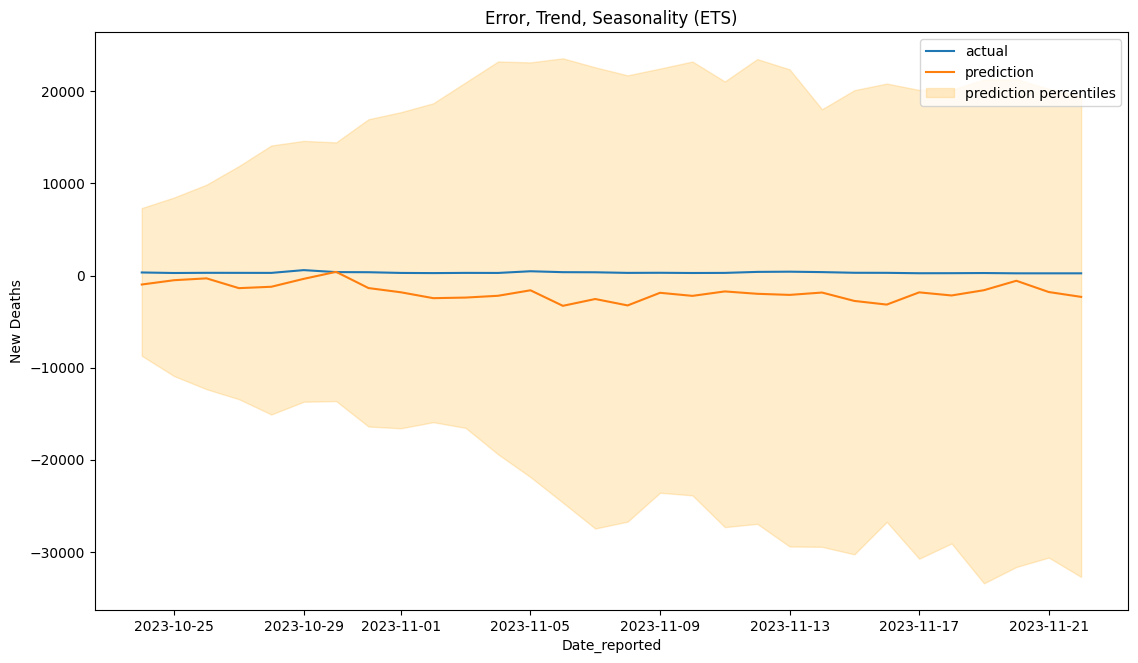

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.fill_between(
    p[date_column],
    p["prediction_5"],
    p["prediction_95"],
    alpha=0.2,
    color="orange",
    label="prediction percentiles",
)
ax.set_title("Error, Trend, Seasonality (ETS)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [11]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 5110030.69
RMSE: 2260.54
MAE: 2091.25
MAPE: 698.10
SMAPE: 193.57


In [12]:
param_grid = {"global_trend_option": ["linear", "loglinear", "flat", "logistic"]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [13]:
global_trend_options = ["linear", "loglinear", "flat", "logistic"]

dlt_scores = dict()


def dlt_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an ETS model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return DLT(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        regressor_col=["New_cases"],
        regressor_sign=["="],
        regression_penalty="auto_ridge",
        damped_factor=0.8,
        seed=2,
        verbose=False,
        **ets_best_params,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, dlt_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        dlt_scores[json.dumps(option)] = score

chain 1 |          | 00:00 Status







































chain 4 |          | 00:00 Status





































































































































































































































chain 1 |█████     | 01:09 Iteration:   1 / 250 [  0%]  (Warmup)



























































































































































































































































































chain 1 |███████▌  | 03:19 Iteration: 100 / 250 [ 40%]  (Warmup)


































chain 1 |██████████| 03:41 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |██████████| 04:00 Sampling completed                     
chain 2 |██████████| 04:00 Sampling completed                     
chain 3 |██████████| 04:00 Sampling completed                     

















































































chain 1 |          | 04:09 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 04:17 Sampling completed                     
chain 2 |██████████| 04:17 Sampling completed                     
chain 3 |██████████| 04:17 Sampling completed                     
chain 4 |██████████| 04:17 Sampling completed                     















































































chain 1 |██████████| 04:24 Sampling completed                     
chain 2 |██████████| 04:24 Sampling completed                     
chain 3 |██████████| 04:24 Sampling completed                     
chain 4 |██████████| 04:24 Sampling completed                     


















































chain 1 |██████████| 04:38 Sampling completed                     
chain 2 |██████████| 04:38 Sampling completed                     
chain 3 |██████████| 04:38 Sampling completed                     
chain 4 |██████████| 04:38 Sampling completed                     

chain 1 |          | 00:00 Status






chain 1 |██▌       | 00:00 Status



























































































chain 1 |█████     | 01:12 Iteration:   1 / 250 [  0%]  (Warmup)























































































































































































































































chain 1 |███████▌  | 02:42 Iteration: 100 / 250 [ 40%]  (Warmup)



















chain 1 |██████████| 03:26 Sampling completed                     
chain 2 |██████████| 03:26 Sampling completed                     
chain 3 |██████████| 03:26 Sampling completed                     
chain 4 |██████████| 03:26 Sampling completed                     














































































chain 1 |██████████| 03:13 Sampling completed                     
chain 2 |██████████| 03:13 Sampling completed                     
chain 3 |██████████| 03:13 Sampling completed                     
chain 4 |██████████| 03:13 Sampling completed                     
























































































chain 1 |██████████| 03:02 Iteration: 200 / 250 [ 80%]  (Warmup)
































chain 1 |          | 03:24 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 03:54 Sampling completed                     
chain 2 |██████████| 03:54 Sampling completed                     
chain 3 |██████████| 03:54 Sampling completed                     
chain 4 |██████████| 03:54 Sampling completed                     




































































chain 1 |██████████| 03:56 Sampling completed                     
chain 2 |██████████| 03:56 Sampling completed                     
chain 3 |██████████| 03:56 Sampling completed                     
chain 4 |██████████| 03:56 Sampling completed                     














chain 1 |          | 00:00 Status



















chain 1 |█████     | 00:41 Iteration:   1 / 250 [  0%]  (Warmup)











































































































































































































































chain 1 |██████████| 03:37 Sampling completed                     
chain 2 |██████████| 03:37 Sampling completed                     
chain 3 |██████████| 03:37 Sampling completed                     
chain 4 |██████████| 03:37 Sampling completed                     




























































































































chain 1 |███████▌  | 02:51 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 04:00 Sampling completed                     
chain 2 |██████████| 04:00 Sampling completed                     
chain 3 |██████████| 04:00 Sampling completed                     
chain 4 |██████████| 04:00 Sampling completed                     












































































































chain 1 |██████████| 03:15 Iteration: 200 / 250 [ 80%]  (Warmup)















































chain 1 |          | 03:39 Iteration: 226 / 250 [ 90%]  (Sampling)














































chain 1 |██████████| 04:22 Sampling completed                     
chain 2 |██████████| 04:22 Sampling completed                     
chain 3 |██████████| 04:22 Sampling completed                     
chain 4 |██████████| 04:22 Sampling completed                     































































chain 1 |██████████| 04:23 Sampling completed                     
chain 2 |██████████| 04:23 Sampling completed                     
chain 3 |██████████| 04:23 Sampling completed                     
chain 4 |██████████| 04:23 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |█████     | 00:21 Iteration:   1 / 250 [  0%]  (Warmup)



















































































































































































chain 1 |██████████| 03:33 Sampling completed                     
chain 2 |██████████| 03:33 Sampling completed                     
chain 3 |██████████| 03:33 Sampling completed                     
chain 4 |██████████| 03:33 Sampling completed                     





















































































chain 1 |███████▌  | 01:44 Iteration: 100 / 250 [ 40%]  (Warmup)
































chain 1 |██████████| 02:07 Iteration: 200 / 250 [ 80%]  (Warmup)






























chain 1 |██████████| 03:41 Sampling completed                     
chain 2 |██████████| 03:41 Sampling completed                     
chain 3 |██████████| 03:41 Sampling completed                     
chain 4 |██████████| 03:41 Sampling completed                     












































































































chain 1 |          | 02:30 Iteration: 226 / 250 [ 90%]  (Sampling)



































































































chain 1 |██████████| 03:29 Sampling completed                     
chain 2 |██████████| 03:29 Sampling completed                     
chain 3 |██████████| 03:29 Sampling completed                     
chain 4 |██████████| 03:29 Sampling completed                     






































































































































































chain 1 |██████████| 04:15 Sampling completed                     
chain 2 |██████████| 04:15 Sampling completed                     
chain 3 |██████████| 04:15 Sampling completed                     
chain 4 |██████████| 04:15 Sampling completed                     

chain 1 |          | 00:00 Status






chain 1 |██▌       | 00:00 Status




























































chain 1 |██████████| 03:25 Sampling completed                     
chain 2 |██████████| 03:25 Sampling completed                     
chain 3 |██████████| 03:25 Sampling completed                     
chain 4 |██████████| 03:25 Sampling completed                     





























chain 1 |█████     | 00:52 Iteration:   1 / 250 [  0%]  (Warmup)






















































































chain 1 |██████████| 03:27 Sampling completed                     
chain 2 |██████████| 03:27 Sampling completed                     
chain 3 |██████████| 03:27 Sampling completed                     
chain 4 |██████████| 03:27 Sampling completed                     











chain 1 |███████▌  | 01:49 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 03:00 Sampling completed                     
chain 2 |██████████| 03:00 Sampling completed                     
chain 3 |██████████| 03:00 Sampling completed                     
chain 4 |██████████| 03:00 Sampling completed                     

chain 1 |██████████| 02:03 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 02:17 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 02:35 Sampling completed                     
chain 2 |██████████| 02:35 Sampling completed                     
chain 3 |██████████| 02:35 Sampling completed                     
chain 4 |██████████| 02:35 Sampling completed                     

In [14]:
dlt_best_params = json.loads(min(dlt_scores, key=dlt_scores.get))
dlt_scores

{'{"global_trend_option": "flat"}': 3081.1552021801012,
 '{"global_trend_option": "logistic"}': 3122.6809979822888,
 '{"global_trend_option": "linear"}': 3086.5281510287064,
 '{"global_trend_option": "loglinear"}': 3033.703296114351}

In [15]:
dlt = DLT(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases"],
    regressor_sign=["="],
    regression_penalty="auto_ridge",
    damped_factor=0.8,
    seed=2,
    verbose=False,
    **ets_best_params,
    **dlt_best_params
)

dlt.fit(train)
p = dlt.predict(df=valid[[date_column, "New_cases"]])
p = p.merge(valid, on=date_column, how="left")

chain 1 |          | 00:00 Status





chain 1 |█████     | 00:16 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |██████████| 01:36 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 01:58 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 03:05 Sampling completed                     
chain 2 |██████████| 03:05 Sampling completed                     
chain 3 |██████████| 03:05 Sampling completed                     
chain 4 |██████████| 03:05 Sampling completed                     

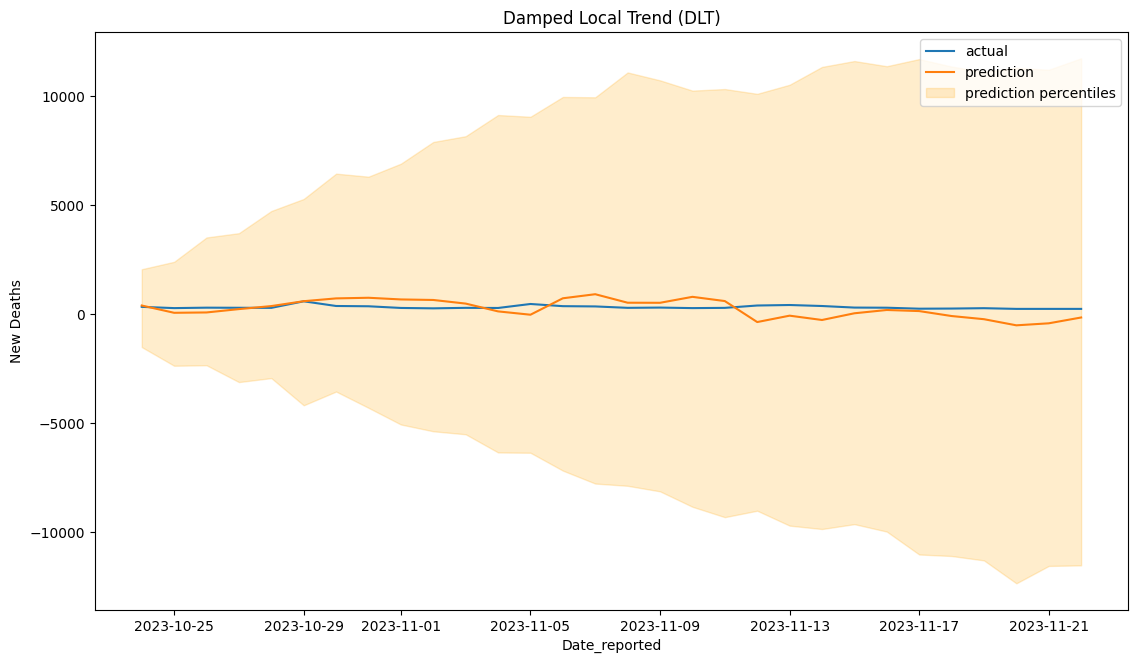

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.fill_between(
    p[date_column],
    p["prediction_5"],
    p["prediction_95"],
    alpha=0.2,
    color="orange",
    label="prediction percentiles",
)
ax.set_title("Damped Local Trend (DLT)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [17]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 158416.90
RMSE: 398.02
MAE: 340.99
MAPE: 113.36
SMAPE: 108.06


In [18]:
ktr = KTR(
    date_col=date_column,
    response_col=target_column,
    seasonality=[90, 180, 360],
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases"],
    seed=2,
    verbose=False,
)

ktr.fit(df=train)

p = ktr.predict(df=valid[[date_column, "New_cases"]])
p = p.merge(valid, on=date_column, how="left")

2023-12-10 12:16:39 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


/home/samuell/.local/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


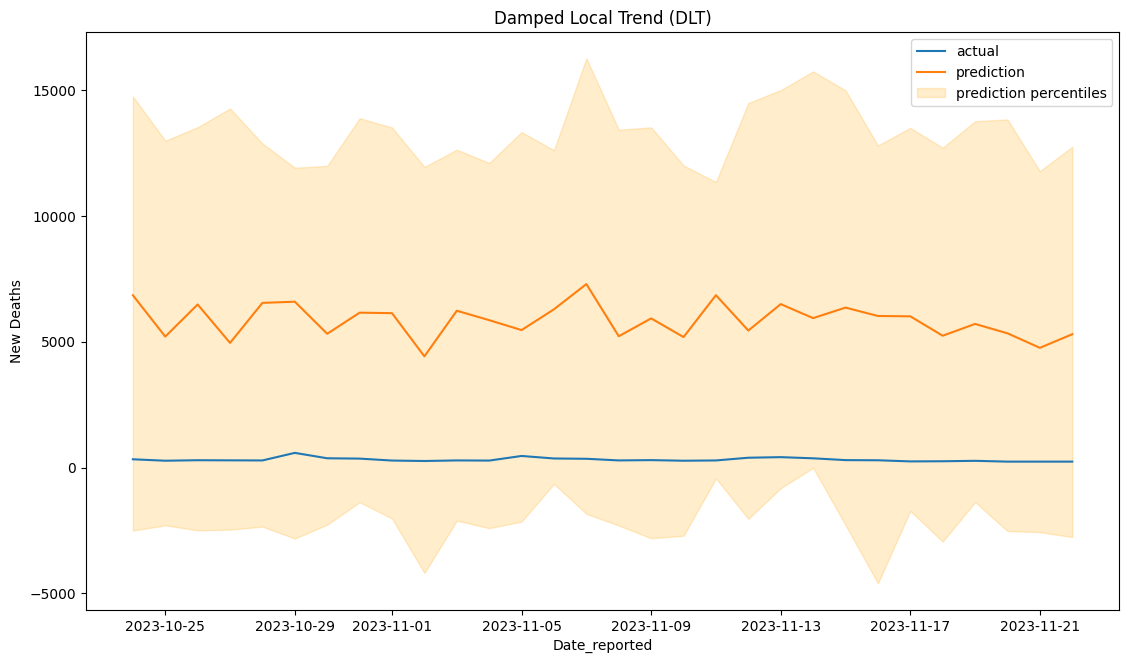

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.fill_between(
    p[date_column],
    p["prediction_5"],
    p["prediction_95"],
    alpha=0.2,
    color="orange",
    label="prediction percentiles",
)
ax.set_title("Damped Local Trend (DLT)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [20]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 31075822.79
RMSE: 5574.57
MAE: 5536.40
MAPE: 1823.69
SMAPE: 179.56
